In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

In [3]:
# 주어지는 정보, converted node, edge, adj

converted_nodes = [{'id': 0, 'type': 'H', 'coords': (10, 10)}, {'id': 1, 'type': 'I', 'coords': (5, 8)}, {'id': 2, 'type': 'S', 'coords': (7, 2)}, {'id': 3, 'type': 'C', 'coords': (6, 0)}, {'id': 4, 'type': 'S', 'coords': (2, 7)}, {'id': 5, 'type': 'C', 'coords': (5, 0)}, {'id': 6, 'type': 'S', 'coords': (2, 2)}, {'id': 7, 'type': 'I', 'coords': (4, 9)}, {'id': 8, 'type': 'O', 'coords': (1, 1)}, {'id': 9, 'type': 'C', 'coords': (5, 1)}, {'id': 10, 'type': 'R', 'coords': (7, 1)}, {'id': 11, 'type': 'R', 'coords': (9, 3)}, {'id': 12, 'type': 'I', 'coords': (4, 8)}, {'id': 13, 'type': 'S', 'coords': (7, 7)}, {'id': 14, 'type': 'C', 'coords': (8, 4)}, {'id': 15, 'type': 'O', 'coords': (2, 1)}, {'id': 16, 'type': 'R', 'coords': (8, 1)}, {'id': 17, 'type': 'R', 'coords': (8, 2)}, {'id': 18, 'type': 'C', 'coords': (1, 3)}, {'id': 19, 'type': 'R', 'coords': (9, 4)}]
converted_edges = [{'start': 0, 'end': 7, 'distance': 12.165525060596439, 'road_type': 'urban'}, {'start': 7, 'end': 0, 'distance': 12.165525060596439, 'road_type': 'urban'}, {'start': 1, 'end': 12, 'distance': 2.0, 'road_type': 'urban'}, {'start': 12, 'end': 1, 'distance': 2.0, 'road_type': 'urban'}, {'start': 2, 'end': 6, 'distance': 10.0, 'road_type': 'highway'}, {'start': 6, 'end': 2, 'distance': 10.0, 'road_type': 'highway'}, {'start': 2, 'end': 13, 'distance': 10.0, 'road_type': 'highway'}, {'start': 13, 'end': 2, 'distance': 10.0, 'road_type': 'highway'}, {'start': 2, 'end': 17, 'distance': 2.0, 'road_type': 'urban'}, {'start': 17, 'end': 2, 'distance': 2.0, 'road_type': 'urban'}, {'start': 3, 'end': 5, 'distance': 2.0, 'road_type': 'urban'}, {'start': 5, 'end': 3, 'distance': 2.0, 'road_type': 'urban'}, {'start': 4, 'end': 6, 'distance': 10.0, 'road_type': 'highway'}, {'start': 6, 'end': 4, 'distance': 10.0, 'road_type': 'highway'}, {'start': 4, 'end': 7, 'distance': 5.656854249492381, 'road_type': 'urban'}, {'start': 7, 'end': 4, 'distance': 5.656854249492381, 'road_type': 'urban'}, {'start': 4, 'end': 13, 'distance': 10.0, 'road_type': 'highway'}, {'start': 13, 'end': 4, 'distance': 10.0, 'road_type': 'highway'}, {'start': 5, 'end': 6, 'distance': 7.211102550927978, 'road_type': 'urban'}, {'start': 6, 'end': 5, 'distance': 7.211102550927978, 'road_type': 'urban'}, {'start': 5, 'end': 9, 'distance': 2.0, 'road_type': 'urban'}, {'start': 9, 'end': 5, 'distance': 2.0, 'road_type': 'urban'}, {'start': 5, 'end': 15, 'distance': 6.324555320336759, 'road_type': 'urban'}, {'start': 15, 'end': 5, 'distance': 6.324555320336759, 'road_type': 'urban'}, {'start': 5, 'end': 17, 'distance': 7.211102550927978, 'road_type': 'urban'}, {'start': 17, 'end': 5, 'distance': 7.211102550927978, 'road_type': 'urban'}, {'start': 6, 'end': 15, 'distance': 2.0, 'road_type': 'urban'}, {'start': 15, 'end': 6, 'distance': 2.0, 'road_type': 'urban'}, {'start': 6, 'end': 18, 'distance': 2.8284271247461903, 'road_type': 'urban'}, {'start': 18, 'end': 6, 'distance': 2.8284271247461903, 'road_type': 'urban'}, {'start': 7, 'end': 12, 'distance': 2.0, 'road_type': 'urban'}, {'start': 12, 'end': 7, 'distance': 2.0, 'road_type': 'urban'}, {'start': 8, 'end': 15, 'distance': 2.0, 'road_type': 'urban'}, {'start': 15, 'end': 8, 'distance': 2.0, 'road_type': 'urban'}, {'start': 10, 'end': 16, 'distance': 2.0, 'road_type': 'urban'}, {'start': 16, 'end': 10, 'distance': 2.0, 'road_type': 'urban'}, {'start': 10, 'end': 17, 'distance': 2.8284271247461903, 'road_type': 'urban'}, {'start': 17, 'end': 10, 'distance': 2.8284271247461903, 'road_type': 'urban'}, {'start': 11, 'end': 19, 'distance': 2.0, 'road_type': 'urban'}, {'start': 19, 'end': 11, 'distance': 2.0, 'road_type': 'urban'}, {'start': 13, 'end': 14, 'distance': 6.324555320336759, 'road_type': 'urban'}, {'start': 14, 'end': 13, 'distance': 6.324555320336759, 'road_type': 'urban'}, {'start': 14, 'end': 17, 'distance': 4.0, 'road_type': 'urban'}, {'start': 17, 'end': 14, 'distance': 4.0, 'road_type': 'urban'}, {'start': 14, 'end': 18, 'distance': 14.142135623730951, 'road_type': 'urban'}, {'start': 18, 'end': 14, 'distance': 14.142135623730951, 'road_type': 'urban'}, {'start': 14, 'end': 19, 'distance': 2.0, 'road_type': 'urban'}, {'start': 19, 'end': 14, 'distance': 2.0, 'road_type': 'urban'}, {'start': 15, 'end': 17, 'distance': 12.165525060596439, 'road_type': 'urban'}, {'start': 17, 'end': 15, 'distance': 12.165525060596439, 'road_type': 'urban'}]

adj = [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0.],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0.],
 [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0.],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0.],
 [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0.],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1.],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0.],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
 [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.]]

edge_idx_map = {(0, 7): 0, (7, 0): 1, (1, 12): 2, (12, 1): 3, (2, 6): 4, (6, 2): 5, (2, 13): 6, (13, 2): 7, (2, 17): 8, (17, 2): 9, (3, 5): 10, (5, 3): 11, (4, 6): 12, (6, 4): 13, (4, 7): 14, (7, 4): 15, (4, 13): 16, (13, 4): 17, (5, 6): 18, (6, 5): 19, (5, 9): 20, (9, 5): 21, (5, 15): 22, (15, 5): 23, (5, 17): 24, (17, 5): 25, (6, 15): 26, (15, 6): 27, (6, 18): 28, (18, 6): 29, (7, 12): 30, (12, 7): 31, (8, 15): 32, (15, 8): 33, (10, 16): 34, (16, 10): 35, (10, 17): 36, (17, 10): 37, (11, 19): 38, (19, 11): 39, (13, 14): 40, (14, 13): 41, (14, 17): 42, (17, 14): 43, (14, 18): 44, (18, 14): 45, (14, 19): 46, (19, 14): 47, (15, 17): 48, (17, 15): 49}
node_idx_map = {0: (0, 7), 1: (7, 0), 2: (1, 12), 3: (12, 1), 4: (2, 6), 5: (6, 2), 6: (2, 13), 7: (13, 2), 8: (2, 17), 9: (17, 2), 10: (3, 5), 11: (5, 3), 12: (4, 6), 13: (6, 4), 14: (4, 7), 15: (7, 4), 16: (4, 13), 17: (13, 4), 18: (5, 6), 19: (6, 5), 20: (5, 9), 21: (9, 5), 22: (5, 15), 23: (15, 5), 24: (5, 17), 25: (17, 5), 26: (6, 15), 27: (15, 6), 28: (6, 18), 29: (18, 6), 30: (7, 12), 31: (12, 7), 32: (8, 15), 33: (15, 8), 34: (10, 16), 35: (16, 10), 36: (10, 17), 37: (17, 10), 38: (11, 19), 39: (19, 11), 40: (13, 14), 41: (14, 13), 42: (14, 17), 43: (17, 14), 44: (14, 18), 45: (18, 14), 46: (14, 19), 47: (19, 14), 48: (15, 17), 49: (17, 15)}

In [4]:
edge_adj_mat = np.zeros((len(edge_idx_map), len(edge_idx_map)))

for edge_info in edge_idx_map:
    id = edge_idx_map[edge_info]
    u, v = edge_info

    for edge_info_2 in edge_idx_map:
        U, V = edge_info_2
        ID = edge_idx_map[edge_info_2]
        if u==U or u==V or v==U or v==V:
            edge_adj_mat[id,ID] = 1
            edge_adj_mat[ID,id] = 1
np.fill_diagonal(edge_adj_mat, 0.0)

In [ ]:
class TrafficDataset(Dataset):
    """
    트래픽 시계열 데이터를 엣지별 시퀀스 + 시간 특성(요일, 시각)과 함께 반환합니다.
    입력: traffic_data (T_total, E, C_all)
    출력: past_edges, future_edges 등
    """
    def __init__(self, traffic_data, window=12, week_steps=480*7):
        super().__init__()
        self.traffic = traffic_data          # (T_total, E, C_all)
        self.window = window                # 과거 시퀀스 길이(12)
        self.week_steps = week_steps
        self.day_steps = week_steps // 7     # 하루당 스텝 수 = 480 (8시간 * 60분)
        self.E = traffic_data.shape[1]       # 엣지 개수

        T_total = traffic_data.shape[0]
        # 과거 window를 사용하므로 시작 인덱스 범위 재계산
        self.min_start = (T_total // week_steps - 1) * week_steps + (self.window - 1)
        # +12까지 참조하므로 max_start = T_total - max(future offsets) - 1
        self.max_start = T_total - 12 - 1
        self.starts = list(range(self.min_start, self.max_start + 1))

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        t0 = self.starts[idx]
        # 1) 과거 window 길이만큼
        past_idxs = np.arange(t0 - self.window + 1, t0 + 1)                  # shape=(12,)
        # 2) 미래 3개 시점: +3, +6, +12
        fut_offsets = np.array([3, 6, 12], dtype=np.int64)
        fut_idxs = t0 + fut_offsets                                         # shape=(3,)

        # raw slice
        past = self.traffic[past_idxs]                                       # (12, E, C_all)
        fut  = self.traffic[fut_idxs]                                        # (3,  E, C_all)

        # 채널 0~2: volume, density, flow
        Xp = torch.from_numpy(past[..., :3]).float()                        # (12, E, 3)
        Xf = torch.from_numpy(fut[...,  :3]).float()                        # (3,  E, 3)

        # 시간 특성
        tod_enc = ((past_idxs % self.day_steps) * 24.0 / self.day_steps).astype(np.float32)
        dow_enc = ((past_idxs // self.day_steps) % 7).astype(np.int64)
        tod_dec = (((fut_idxs) % self.day_steps) * 24.0 / self.day_steps).astype(np.float32)
        dow_dec = (((fut_idxs) // self.day_steps) % 7).astype(np.int64)

        # (seq, E, 1)
        tod_feat_enc = torch.from_numpy(tod_enc)[:, None].expand(-1, self.E).unsqueeze(-1)
        dow_feat_enc = torch.from_numpy(dow_enc).float()[:, None].expand(-1, self.E).unsqueeze(-1)
        tod_feat_dec = torch.from_numpy(tod_dec)[:, None].expand(-1, self.E).unsqueeze(-1)
        dow_feat_dec = torch.from_numpy(dow_dec).float()[:, None].expand(-1, self.E).unsqueeze(-1)

        # 최종 엣지 피처
        past_edges   = torch.cat([Xp, tod_feat_enc, dow_feat_enc], dim=-1)   # (12, E, 5)
        future_edges = torch.cat([Xf, tod_feat_dec, dow_feat_dec], dim=-1)   # (3,  E, 3)
        future_edges = future_edges[:,:,:3]

        # 장기 히스토리 (5주치)
        K = self.traffic.shape[0] // self.week_steps
        hist_long = torch.zeros((self.window, self.E, K, 3), dtype=torch.float32)
        for tau in range(1, self.window + 1):
            for k in range(1, K + 1):
                t_hist = t0 + tau - k * self.week_steps
                frame = self.traffic[t_hist]
                hist_long[tau-1, :, k-1] = torch.from_numpy(frame[:, :3])

        return {
            'past_edges':   past_edges,    # (12, E, 5) # 0 volume, 1 density, 2 flow, 3 tod, 4 dow
            'future_edges': future_edges,  # (3,  E, 3)
            'hist_long':    hist_long,     # (12, E, K, 3)
        }


In [ ]:
# 4 classic baselines
# --- CNN + LSTM -----------------------------------------------------------
class CNN_LSTM(nn.Module):
    def __init__(self, E, in_channels=5, cnn_channels=32, lstm_hidden=64, out_steps=3, out_channels=3, kernel_size=3):
        super().__init__()
        padding = (kernel_size - 1)//2
        self.E = E
        self.out_steps = out_steps
        self.out_channels = out_channels
        self.cnn = nn.Conv1d(in_channels, cnn_channels, kernel_size, padding=padding)
        self.lstm = nn.LSTM(cnn_channels*E, lstm_hidden, batch_first=True)
        self.fc   = nn.Linear(lstm_hidden, out_steps * E * out_channels)

    def forward(self, x):
        # x: (B, T, E, C)
        B, T, E, C = x.shape
        x_c = x.permute(0,1,3,2).reshape(B*T, C, E)       # (B*T, C, E)
        f   = F.relu(self.cnn(x_c))                      # (B*T, cnnC, E)
        f   = f.reshape(B, T, -1)                        # (B, T, cnnC*E)
        out, _ = self.lstm(f)                            # (B, T, lstm_hidden)
        h_last = out[:, -1, :]                           # (B, lstm_hidden)
        y = self.fc(h_last)                              # (B, out_steps*E*out_channels)
        return y.view(B, self.out_steps, E, self.out_channels)  # (B, out_steps, E, out_channels)

# --- MLP + LSTM -----------------------------------------------------------
class MLP_LSTM(nn.Module):
    def __init__(self, E, in_channels=5, mlp_hidden=64, lstm_hidden=64, out_steps=3, out_channels=3):
        super().__init__()
        self.E = E
        self.out_steps = out_steps
        self.out_channels = out_channels
        self.mlp  = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, mlp_hidden)
        )
        self.lstm = nn.LSTM(mlp_hidden*E, lstm_hidden, batch_first=True)
        self.fc   = nn.Linear(lstm_hidden, out_steps * E * out_channels)

    def forward(self, x):
        # x: (B, T, E, C)
        B, T, E, C = x.shape
        x_m = x.view(B*T*E, C)                          # (B*T*E, C)
        f   = self.mlp(x_m)                             # (B*T*E, mlp_hidden)
        f   = f.view(B, T, E * f.size(-1))              # (B, T, mlp_hidden*E)
        out, _ = self.lstm(f)                           # (B, T, lstm_hidden)
        h_last = out[:, -1, :]                          # (B, lstm_hidden)
        y = self.fc(h_last)                             # (B, out_steps*E*out_channels)
        return y.view(B, self.out_steps, E, self.out_channels)  # (B, out_steps, E, out_channels)

# STGCN & STGAT GNN baseline
# --- STGCN ----------------------------------------------------------------
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.temp1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=(1, kernel_size),
                               stride=(1, stride),
                               padding=(0, padding))
        self.temp2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=(1, kernel_size),
                               stride=(1, stride),
                               padding=(0, padding))
        self.relu = nn.ReLU()
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, x, A):
        # x: (B, C, T, E)
        x = self.relu(self.temp1(x))         # (B, midC, T, E)
        B, C, T, E = x.shape
        if A.shape[0] != E:
            A = A[:E, :E]
        x_gc = torch.einsum('bctv,vw->bctw', x, A)
        x = self.relu(self.temp2(x_gc))      # (B, outC, T, E)
        y = x.permute(0,2,3,1)               # (B, T, E, C)
        y = self.layer_norm(y)
        return y.permute(0,3,1,2)            # (B, C, T, E)

class STGCN(nn.Module):
    def __init__(self, E, A, in_channels=5, hidden_channels=64, out_channels=3):
        super().__init__()
        self.E = E
        self.A = A
        self.out_channels = out_channels
        self.block1 = STGCNBlock(in_channels, hidden_channels)
        self.block2 = STGCNBlock(hidden_channels, hidden_channels)
        self.final_conv = nn.Conv2d(hidden_channels, out_channels, (1,1))

    def forward(self, x):
        # x: (B, T, E, C)
        B, T, E, C = x.shape
        x = x.permute(0,3,1,2)                # (B, C, T, E)
        x = self.block1(x, self.A)
        x = self.block2(x, self.A)
        y = self.final_conv(x)               # (B, out_channels, T, E)
        y = y.permute(0,2,3,1)               # (B, T, E, out_channels)
        # select time indices 2,5,11 for +3,+6,+12
        idx = torch.tensor([2,5,11], device=y.device)
        return y[:, idx, :, :]               # (B, 3, E, out_channels)

# --- STGAT ----------------------------------------------------------------
class STGATLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads=1):
        super().__init__()
        self.attn = nn.MultiheadAttention(in_channels, num_heads, batch_first=True)
        self.fc = nn.Conv1d(in_channels, out_channels, 1)
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        # x: (B, C, T, E)
        B, C, T, E = x.shape
        x_flat = x.permute(0,3,2,1).reshape(B*E, T, C)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        out = attn_out.reshape(B, E, T, C).permute(0,3,2,1)
        ff = self.fc(out.reshape(B, C, T*E))
        ff = ff.reshape(B, -1, T, E)
        y = self.layer_norm(ff.permute(0,2,3,1))
        return y.permute(0,3,1,2)            # (B, C, T, E)

class STGAT(nn.Module):
    def __init__(self, E, in_channels=5, hidden_channels=64, out_channels=3, num_heads=1):
        super().__init__()
        self.E = E
        self.out_channels = out_channels
        self.layer1 = STGATLayer(in_channels, hidden_channels, num_heads)
        self.layer2 = STGATLayer(hidden_channels, hidden_channels, num_heads)
        self.final_conv = nn.Conv2d(hidden_channels, out_channels, (1,1))

    def forward(self, x):
        # x: (B, T, E, C)
        B, T, E, C = x.shape
        x = x.permute(0,3,1,2)                # (B, C, T, E)
        x = self.layer1(x)
        x = self.layer2(x)
        y = self.final_conv(x)               # (B, out_channels, T, E)
        y = y.permute(0,2,3,1)               # (B, T, E, out_channels)
        idx = torch.tensor([2,5,11], device=y.device)
        return y[:, idx, :, :]               # (B, 3, E, out_channels)

In [6]:
# T-Graphormer (SOTA)

# Graphormer-style Transformer Layer with spatial bias
class GraphormerLayer(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm2 = nn.LayerNorm(d_model)
        ffn_hidden = 4 * d_model
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_hidden, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x, attn_bias):
        # x: (B, L, d_model)
        # attn_bias: (L, L) broadcastable to (B, num_heads, L, L)
        res = x
        x = self.norm1(x)
        # MultiheadAttention with additive bias via attn_mask
        attn_out, _ = self.attn(
            x, x, x,
            attn_mask=attn_bias
        )
        x = res + attn_out
        res2 = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = res2 + x
        return x

# T-Graphormer implementation tailored to our dataset
class TGraphormer(nn.Module):
    def __init__(
        self,
        E,
        window=12,
        d_model=32,
        num_layers=2,
        num_heads=4,
        dropout=0.1,
        kappa=30
    ):
        super().__init__()
        self.E = E
        self.window = window
        self.d_model = d_model
        self.out_steps = 3  # predict +3, +6, +12
        self.out_dim = 3    # predict (volume, density, flow)

        # Project traffic features (3 channels) to d_model
        self.W0 = nn.Linear(3, d_model)
        # Time-of-day embedding: 24 bins (20-minute intervals)
        self.tod_emb = nn.Embedding(24, d_model)
        # Positional embedding for (window * E) tokens
        L = window * E
        self.pos_emb = nn.Parameter(torch.randn(1, L, d_model))

        # Build spatial adjacency via thresholded Gaussian kernel
        coords = np.array([n['coords'] for n in converted_nodes])  # (E, 2)
        # Compute pairwise Euclidean distances
        dmat = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
        # σ: standard deviation over provided edge distances
        edge_dists = np.array([e['distance'] for e in converted_edges])
        sigma = edge_dists.std()
        # Gaussian kernel with threshold kappa
        W = np.exp(- (dmat ** 2) / (sigma ** 2))
        W[dmat > kappa] = 0
        W = torch.from_numpy(W).float()
        self.register_buffer('W', W)
        # Expand to block-diagonal for attention bias: kron(I_T, W)
        I = torch.eye(window)
        W_big = torch.kron(I, W)  # (L, L)
        self.register_buffer('attn_bias', W_big)

        # Transformer layers
        self.layers = nn.ModuleList([
            GraphormerLayer(d_model, num_heads, dropout)
            for _ in range(num_layers)
        ])
        # Prediction head: from d_model to out_steps * out_dim
        self.pred = nn.Linear(d_model, self.out_steps * self.out_dim)

    def forward(self, x):
        # x: (B, T, E, C=5) channels=(vol, den, flow, tod, dow)
        B, T, E, C = x.shape
        # 1) Traffic features
        traffic = x[..., :3]           # (B, T, E, 3)
        # 2) Time-of-day bin index from channel 3 (float tod ~ step/20)
        tod = x[..., 3]                # (B, T, E)
        tod_idx = torch.floor(tod).long().clamp(0, 23)  # bins 0..23
        tod_feat = self.tod_emb(tod_idx)  # (B, T, E, d_model)

        # 3) Project traffic
        traf_feat = self.W0(traffic)    # (B, T, E, d_model)
        # 4) Initial node embeddings
        h = traf_feat + tod_feat        # (B, T, E, d_model)
        # 5) Flatten to token sequence
        h = h.view(B, T * E, self.d_model)  # (B, L, d_model)
        # 6) Add positional embedding
        h = h + self.pos_emb            # (B, L, d_model)

        # 7) Transformer Encoder with spatial bias
        for layer in self.layers:
            h = layer(h, self.attn_bias)

        # 8) Unflatten back to (B, T, E, d_model)
        h = h.view(B, T, E, self.d_model)
        # 9) Use last time step as context
        h_last = h[:, -1, :, :]         # (B, E, d_model)
        # 10) Predict future
        y = self.pred(h_last)           # (B, E, out_steps * out_dim)
        y = y.view(B, E, self.out_steps, self.out_dim)
        # (B, E, 3, 3) -> permute to (B, 3, E, 3)
        y = y.permute(0, 2, 1, 3)
        return y  # (B, 3, E, 3)

In [4]:
# 보조 네트워크 2종
class ShortPatternNet(nn.Module):
    """
    f_short: summarizes past 60-min edge series into a per-edge embedding of dim L.
    Input:
        past_edges: (B, T, E, C=3)
        time_feats: (B, E, d_time) e.g. day_emb + time_pe → (8+2)=10
    Output:
        e_short: (B, E, L=32)
    """
    def __init__(self, C=3, d_c=64, d_time=10, L=32):
        super().__init__()
        # 1D-CNN over time axis
        self.conv1 = nn.Conv1d(C, d_c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(d_c, d_c, kernel_size=3, padding=1)
        # MLP to L
        self.mlp = nn.Sequential(
            nn.Linear(d_c + d_time, L),
            nn.ReLU(),
            nn.Linear(L, L)
        )

    def forward(self, past_edges, time_feats):
        # past_edges: B x T x E x C
        B, T, E, C = past_edges.shape
        # permute to (B*E, C, T)
        x = past_edges.permute(0,2,3,1).reshape(B*E, C, T)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # global avg pool over time: (B*E, d_c, 1) -> (B*E, d_c)
        x = x.mean(dim=-1)
        # reshape to (B, E, d_c)
        x = x.view(B, E, -1)
        # concat time_feats: (B, E, d_time)
        x = torch.cat([x, time_feats], dim=-1)  # (B, E, d_c + d_time)
        # MLP to produce e_short
        e_short = self.mlp(x)  # (B, E, L)
        return e_short

class LongPatternNet(nn.Module):
    """
    f_long: summarizes history from 5 past weeks for each future step into per-edge embedding of dim L.
    """
    def __init__(self, C=3, K=5, d_q=32, L=32, d_time=10):
        super().__init__()
        self.d_q = d_q                 # ← 추가
        self.query_proj = nn.Linear(d_time, d_q)
        self.key_proj   = nn.Linear(C, d_q)
        self.value_proj = nn.Linear(C, d_q)
        self.mlp = nn.Sequential(
            nn.Linear(d_q + d_time, L),
            nn.ReLU(),
            nn.Linear(L, L)
        )

    def forward(self, hist_long, time_feats):
        # hist_long: B x T_out x E x K x C
        B, T_out, E, K, C = hist_long.shape

        # 1) query 생성
        q = self.query_proj(time_feats)  # (B, T_out, E, d_q)

        # 2) keys & values 생성
        hv = hist_long.view(B*T_out*E*K, C)
        k  = self.key_proj(hv).view(B, T_out, E, K, self.d_q)
        v  = self.value_proj(hv).view(B, T_out, E, K, self.d_q)

        # 3) attention scores (dot‑product) 및 softmax
        q_exp = q.unsqueeze(3)  # (B, T_out, E, 1, d_q)
        attn_scores  = (q_exp * k).sum(-1) / (self.d_q ** 0.5)  # (B, T_out, E, K)
        attn_weights = torch.softmax(attn_scores, dim=-1)     # (B, T_out, E, K)

        # 4) weighted sum of values
        e = (attn_weights.unsqueeze(-1) * v).sum(3)  # (B, T_out, E, d_q)

        # 5) MLP 결합
        x = torch.cat([e, time_feats], dim=-1)       # (B, T_out, E, d_q + d_time)
        e_long = self.mlp(x)                         # (B, T_out, E, L)
        return e_long


In [ ]:
# 메인 네트워크
class TrafficTransformer(nn.Module):
    def __init__(self, 
                 E, N, edge_attn_mask,
                 C_edge=3, C_node=0,
                 H=128, 
                 num_heads=4, 
                 num_enc_layers=3, 
                 num_dec_layers=3, 
                 d_d=8, d_time=2,
                 L=32):
        super().__init__()
        self.E = E
        self.H = H
        self.L = L
        self.C_edge = C_edge
        self.mix_proj = nn.Linear(self.H + 2*self.L, self.H)

        self.f_short = ShortPatternNet(C_edge, d_c=64, d_time=d_d+d_time, L=L)
        self.f_long  = LongPatternNet(C_edge, K=5, d_q=L, L=L, d_time=d_d+d_time)

        # Time embeddings for encoder
        self.day_embed = nn.Embedding(7, d_d)
        # no params for sin/cos
        
        # Initial edge projection
        self.edge_proj = nn.Linear(C_edge + d_d + d_time, H)
        
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(H, num_heads, edge_attn_mask) for _ in range(num_enc_layers)
        ])
        
        # Decoder initial query token
        self.start_token = nn.Parameter(torch.randn(1, 1, H))
        
        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(H, num_heads) for _ in range(num_dec_layers)
        ])
        
        # Output projection
        self.out_proj = nn.Linear(H, C_edge)
    
    def forward(self, past_edges, hist_long, 
                day_idxs_enc, time_of_day_enc,
                time_feats_short, time_feats_long):
        """
        past_edges: (B, T_in, E, C_edge)
        hist_long: (B, T_out, E, K, C_edge)
        day_idxs_enc: (B, T_in, E) long tensor
        time_of_day_enc: (B, T_in, E) float tensor in [0,24)
        time_feats_short: (B, E, d_d+d_time)
        time_feats_long: (B, T_out, E, d_d+d_time)
        """
        B, T, E, C = past_edges.shape
        device = past_edges.device
        
        # 1) Encoder input embedding
        # day embedding
        day_emb = self.day_embed(day_idxs_enc)                     # (B,T,E,d_d)
        # time PE sin/cos
        phase = time_of_day_enc / 24.0
        angles = 2 * math.pi * phase
        pe_sin = torch.sin(angles)[...,None]
        pe_cos = torch.cos(angles)[...,None]
        time_pe = torch.cat([pe_sin, pe_cos], dim=-1)             # (B,T,E,2)
        
        x = torch.cat([past_edges, day_emb, time_pe], dim=-1)     # (B,T,E,C+d_d+2)
        x = self.edge_proj(x)                                     # (B,T,E,H)
        
        # 2) Encoder stacks
        for layer in self.encoder_layers:
            x = layer(x)  # (B,T,E,H)
        
        h_enc = x  # (B,T,E,H)
        H = h_enc.shape[3]

        # 3) Generate initial decoder query
        # repeat start_token to B x (T_out*E) x H
        T_out = hist_long.size(1)
        q = self.start_token.expand(B, T_out*E, H)  # (B, T_out*E, H)
        
        # 4) Incorporate pattern embeddings into decoder query
        # reshape q -> (B, T_out, E, H)
        q_resh = q.view(B, T_out, E, H)
        # concat e_short and e_long into query positions
        # time_feats_short: (B, E, d_d+d_time)
        # time_feats_long: (B, T_out, E, d_d+d_time) assumed precalc
        # here, dummy pattern nets outputs provided externally
        # e_short: (B, E, L)
        e_short = self.f_short(past_edges, time_feats_short)
        # e_long : (B, T_out, E, L)
        e_long  = self.f_long(hist_long, time_feats_long)

        # concat along last dim and project
        q_mix = torch.cat([q_resh, e_short.unsqueeze(1).expand(-1,T_out,-1,-1), e_long], dim=-1)  # (B,T_out,E,H+2L)
        q_mix = self.mix_proj(q_mix)
        q = q_mix.view(B, T_out*E, H)
        
        # 5) Decoder stacks
        memory = h_enc.view(B, T*E, H)
        for layer in self.decoder_layers:
            q = layer(q, memory)
        
        # 6) Output projection
        y = self.out_proj(q)                      # (B, T_out*E, C_edge)
        y = y.view(B, T_out, E, self.C_edge)
        return y

class EncoderLayer(nn.Module):
    def __init__(self, H, num_heads, edge_attn_mask):
        super().__init__()
        self.spatial_attn = nn.MultiheadAttention(H, num_heads, batch_first=True)
        self.edge_attn_mask = edge_attn_mask  # (E, E) bool tensor
        self.temporal_attn = nn.MultiheadAttention(H, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(H, 4*H),
            nn.GELU(),
            nn.Linear(4*H, H)
        )
        self.norm1 = nn.LayerNorm(H)
        self.norm2 = nn.LayerNorm(H)
        self.norm3 = nn.LayerNorm(H)

    def forward(self, x):
        # x: (B, T, E, H)
        B, T, E, H = x.shape

        # 1) Spatial Self-Attention over E, with mask
        x_spat = x.view(B*T, E, H)  # (B*T, E, H)
        # attn_mask shape: (seq_len, seq_len) = (E, E)
        spat_out, _ = self.spatial_attn(x_spat, x_spat, x_spat,
                                        attn_mask=self.edge_attn_mask.to(x.device))
        spat_out = spat_out.view(B, T, E, H)
        x = self.norm1(x + spat_out)

        # 2) Temporal Self-Attention (기존 그대로)
        x_temp = x.permute(0,2,1,3).contiguous().view(B*E, T, H)
        temp_out, _ = self.temporal_attn(x_temp, x_temp, x_temp)
        temp_out = temp_out.view(B, E, T, H).permute(0,2,1,3)
        x = self.norm2(x + temp_out)

        # 3) FFN
        x2 = self.ffn(x)
        x = self.norm3(x + x2)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, H, num_heads):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(H, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(H, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(H, 4*H),
            nn.GELU(),
            nn.Linear(4*H, H)
        )
        self.norm1 = nn.LayerNorm(H)
        self.norm2 = nn.LayerNorm(H)
        self.norm3 = nn.LayerNorm(H)
    
    def forward(self, q, memory):
        # q: (B, S, H), memory: (B, M, H)
        # 1) masked self-attn
        attn_mask = torch.triu(torch.ones(q.size(1), q.size(1), device=q.device), diagonal=1).bool()
        q2, _ = self.self_attn(q, q, q, attn_mask=attn_mask)
        q = self.norm1(q + q2)
        # 2) cross-attn
        q2, _ = self.cross_attn(q, memory, memory)
        q = self.norm2(q + q2)
        # 3) ffn
        q2 = self.ffn(q)
        q = self.norm3(q + q2)
        return q


In [7]:
# Trainer Class
class Trainer:
    def __init__(self, model, train_loader, valid_loader,
                 optimizer, criterion, epochs=10, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.device = device

        # 기록 저장
        self.history = {
            'train_loss': [],
            'valid_loss': [],
            'train_mape': [],
            'valid_mape': []
        }
        self.best_val_loss = float('inf')
        self.no_improve = 0
        self.scaler = GradScaler()
        # 실시간 플롯
        self.fig, self.ax = plt.subplots()

    @staticmethod
    def mape(pred, true):
        mask = true.abs() > 1e-3
        return (torch.abs((pred[mask] - true[mask]) / true[mask])).mean().item()

    def plot_live(self, epoch):
        self.ax.clear()
        xs = range(1, epoch+1)
        self.ax.plot(xs, self.history['train_loss'], label='Train Loss')
        self.ax.plot(xs, self.history['valid_loss'], label='Valid Loss')
        self.ax.plot(xs, self.history['train_mape'], label='Train MAPE')
        self.ax.plot(xs, self.history['valid_mape'], label='Valid MAPE')
        self.ax.set_xlabel('Epoch')
        self.ax.legend()
        clear_output(wait=True)
        display(self.fig)
        self.fig.canvas.draw()

    def fit(self):
        for epoch in range(1, self.epochs+1):
            # Training
            self.model.train()
            total_loss = 0.0
            total_mape = 0.0
            n = 0
            for batch in self.train_loader:
                past = batch['past_edges'].to(self.device)
                fut  = batch['future_edges'].to(self.device)
                B = past.size(0)
                with autocast():
                    pred = self.model(past)
                    loss = self.criterion(pred, fut)
                self.optimizer.zero_grad()
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                total_loss += loss.item() * B
                total_mape += self.mape(pred, fut) * B
                n += B

            train_loss = total_loss / n
            train_mape = total_mape / n

            # Validation
            self.model.eval()
            val_loss = 0.0
            val_mape = 0.0
            n = 0
            with torch.no_grad():
                for batch in self.valid_loader:
                    past = batch['past_edges'].to(self.device)
                    fut  = batch['future_edges'].to(self.device)
                    B = past.size(0)
                    pred = self.model(past)
                    loss = self.criterion(pred, fut)
                    total_loss_val = loss.item() * B
                    total_mape_val = self.mape(pred, fut) * B
                    val_loss += total_loss_val
                    val_mape += total_mape_val
                    n += B

            valid_loss = val_loss / n
            valid_mape = val_mape / n

            # 기록
            self.history['train_loss'].append(train_loss)
            self.history['valid_loss'].append(valid_loss)
            self.history['train_mape'].append(train_mape)
            self.history['valid_mape'].append(valid_mape)

            # 플롯
            if epoch % 2 == 0:
                self.plot_live(epoch)

            # Early stopping
            if valid_loss < self.best_val_loss:
                self.best_val_loss = valid_loss
                self.no_improve = 0
            else:
                self.no_improve += 1
                if self.no_improve >= 5:
                    print(f"Early stopping at epoch {epoch}")
                    break

            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Valid Loss={valid_loss:.4f},"
                  f" Train MAPE={train_mape:.4f}, Valid MAPE={valid_mape:.4f}")

    def get_history(self):
        return self.history


# 실행부

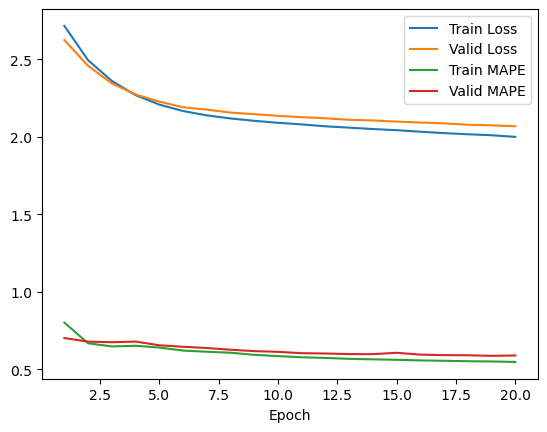

Epoch 20: Train Loss=2.0003, Valid Loss=2.0688, Train MAPE=0.5486, Valid MAPE=0.5901

STGCN:
Final Train Loss: 1.7787337555335119
Final Valid Loss: 1.9415778883353014
Final Train MAPE: 0.5550187745919595
Final Valid MAPE: 0.606948598777244

STGAT:
Final Train Loss: 2.2798089327720494
Final Valid Loss: 2.2905948076521097
Final Train MAPE: 0.662628724024846
Final Valid MAPE: 0.6868637874521536

CNN_LSTM:
Final Train Loss: 1.9970956238416524
Final Valid Loss: 2.077724837921035
Final Train MAPE: 0.5461943034942334
Final Valid MAPE: 0.5902198624889544

MLP_LSTM:
Final Train Loss: 2.000331793840115
Final Valid Loss: 2.068793609769608
Final Train MAPE: 0.5485710066098434
Final Valid MAPE: 0.5900874083757329


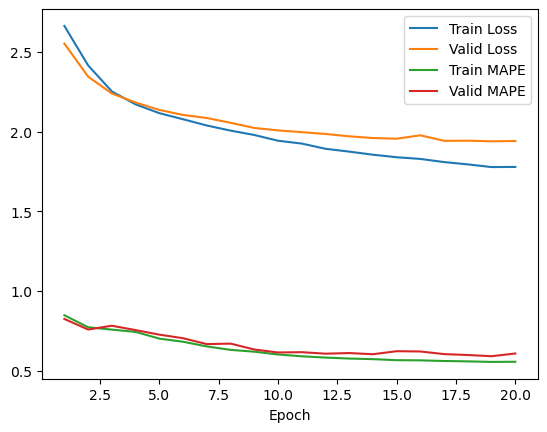

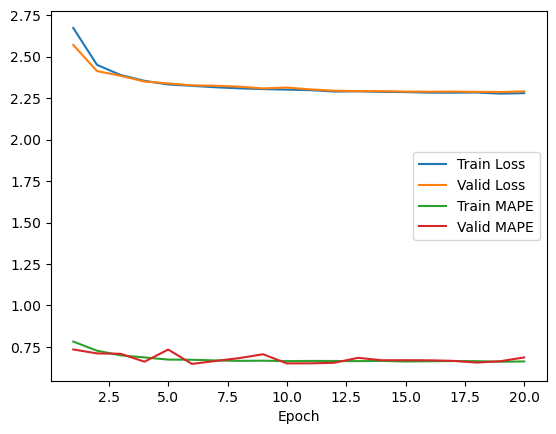

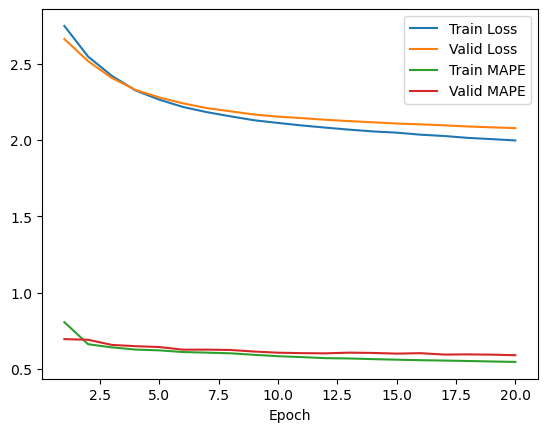

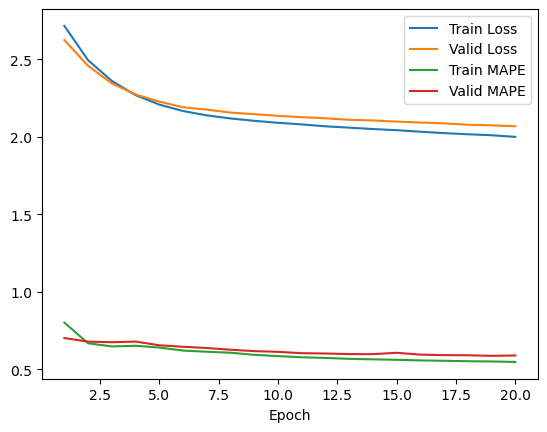

In [9]:

# 0) Hyperparameters
WINDOW = 12
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) 데이터 준비
# traffic_dataset: np.ndarray of shape (T_total, E, C_all)
traffic_dataset = np.load(f'../dataset/traffic_dataset_13.npy')
T_total, E, C_all = traffic_dataset.shape
A = torch.from_numpy(edge_adj_mat).float().to(DEVICE)

# split index (70/20/10)
train_end = int(0.7 * T_total)
valid_end = int(0.9 * T_total)

train_data = traffic_dataset[:train_end]
valid_data = traffic_dataset[train_end:valid_end]

train_ds = TrafficDataset(train_data, window=WINDOW)
valid_ds = TrafficDataset(valid_data, window=WINDOW)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# 3) 모델별 학습
models = {
    'STGCN': STGCN(E=E, A=A, in_channels=5, hidden_channels=64, out_channels=3).to(DEVICE),
    'STGAT': STGAT(E=E, in_channels=5, hidden_channels=64, out_channels=3).to(DEVICE),
    'CNN_LSTM': CNN_LSTM(E=E, in_channels=5, cnn_channels=32, lstm_hidden=64, out_channels=3).to(DEVICE),
    'MLP_LSTM': MLP_LSTM(E=E, in_channels=5, mlp_hidden=64, lstm_hidden=64, out_channels=3).to(DEVICE),
}

histories = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = torch.nn.HuberLoss()  # T-Graphormer의 선례를 따라 HuberLoss 활용

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=EPOCHS,
        device=DEVICE
    )
    trainer.fit()

    # 학습 결과 저장
    histories[name] = trainer.get_history()

# 4) 결과 비교
for name, hist in histories.items():
    print(f"\n{name}:")
    print("Final Train Loss:", hist['train_loss'][-1])
    print("Final Valid Loss:", hist['valid_loss'][-1])
    print("Final Train MAPE:", hist['train_mape'][-1])
    print("Final Valid MAPE:", hist['valid_mape'][-1])



=== Training T_Graphormer ===


C:\Users\gauoo\AppData\Local\Temp\ipykernel_6068\1398967625.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
C:\Users\gauoo\AppData\Local\Temp\ipykernel_6068\1398967625.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


RuntimeError: The shape of the 2D attn_mask is torch.Size([240, 240]), but should be (600, 600).

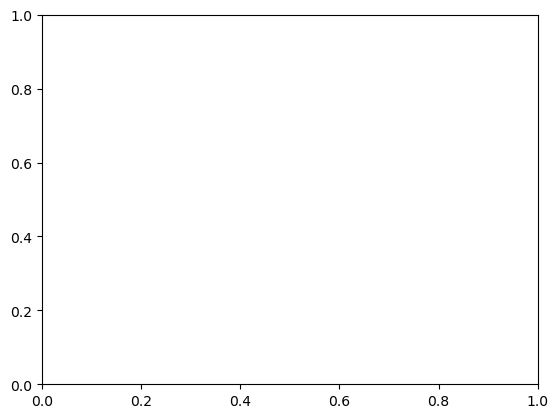

In [8]:

# 0) Hyperparameters
WINDOW = 12
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) 데이터 준비
# traffic_dataset: np.ndarray of shape (T_total, E, C_all)
traffic_dataset = np.load(f'../dataset/traffic_dataset_13.npy')
T_total, E, C_all = traffic_dataset.shape
A = torch.from_numpy(edge_adj_mat).float().to(DEVICE)

# split index (70/20/10)
train_end = int(0.7 * T_total)
valid_end = int(0.9 * T_total)

train_data = traffic_dataset[:train_end]
valid_data = traffic_dataset[train_end:valid_end]

train_ds = TrafficDataset(train_data, window=WINDOW)
valid_ds = TrafficDataset(valid_data, window=WINDOW)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# 3) 모델별 학습
models = {
    'T_Graphormer' : TGraphormer(E=E, window=12, d_model=32, num_layers=2, num_heads=4, dropout=0.1, kappa=30)
}

histories = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = torch.nn.HuberLoss()  # T-Graphormer의 선례를 따라 HuberLoss 활용

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=EPOCHS,
        device=DEVICE
    )
    trainer.fit()

    # 학습 결과 저장
    histories[name] = trainer.get_history()

# 4) 결과 비교
for name, hist in histories.items():
    print(f"\n{name}:")
    print("Final Train Loss:", hist['train_loss'][-1])
    print("Final Valid Loss:", hist['valid_loss'][-1])
    print("Final Train MAPE:", hist['train_mape'][-1])
    print("Final Valid MAPE:", hist['valid_mape'][-1])


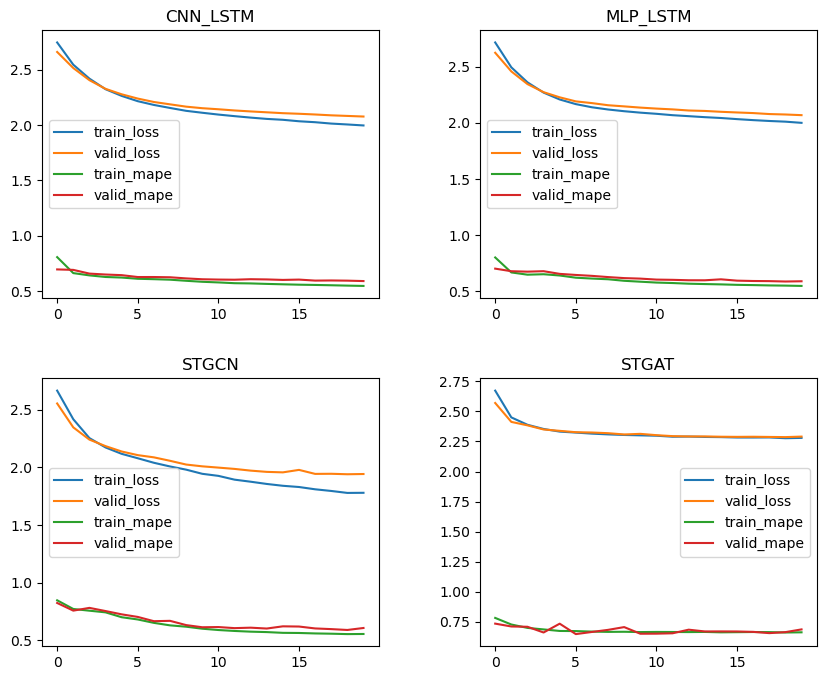

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plt.title('training histories')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0, 0].plot(histories['CNN_LSTM']['train_loss'], label='train_loss')
axs[0, 0].plot(histories['CNN_LSTM']['valid_loss'], label='valid_loss')
axs[0, 0].plot(histories['CNN_LSTM']['train_mape'], label='train_mape')
axs[0, 0].plot(histories['CNN_LSTM']['valid_mape'], label='valid_mape')
axs[0, 0].set_title('CNN_LSTM')
axs[0, 0].legend()

axs[0, 1].plot(histories['MLP_LSTM']['train_loss'], label='train_loss')
axs[0, 1].plot(histories['MLP_LSTM']['valid_loss'], label='valid_loss')
axs[0, 1].plot(histories['MLP_LSTM']['train_mape'], label='train_mape')
axs[0, 1].plot(histories['MLP_LSTM']['valid_mape'], label='valid_mape')
axs[0, 1].set_title('MLP_LSTM')
axs[0, 1].legend()

axs[1, 0].plot(histories['STGCN']['train_loss'], label='train_loss')
axs[1, 0].plot(histories['STGCN']['valid_loss'], label='valid_loss')
axs[1, 0].plot(histories['STGCN']['train_mape'], label='train_mape')
axs[1, 0].plot(histories['STGCN']['valid_mape'], label='valid_mape')
axs[1, 0].set_title('STGCN')
axs[1, 0].legend()

axs[1, 1].plot(histories['STGAT']['train_loss'], label='train_loss')
axs[1, 1].plot(histories['STGAT']['valid_loss'], label='valid_loss')
axs[1, 1].plot(histories['STGAT']['train_mape'], label='train_mape')
axs[1, 1].plot(histories['STGAT']['valid_mape'], label='valid_mape')
axs[1, 1].set_title('STGAT')
axs[1, 1].legend()

plt.show()